# SQL-Like Window functions in Pandas

**1st January 2022**

> tl;dr
>
> Use .groupby and .transform to achieve SQL-like window functionality in Pandas

Slicing and dicing data using Pandas and SQL is a key skillset for any Data Scientist.

Data Scientists will typically work with both SQL and Pandas for transforming data depending on the specific use case and where the data is stored. SQL is typically used when working directly with data in a database i.e. creating new tables or views of the data. Pandas is used more often for a more exploratory analysis and visualisation workflows.

It is important to be fluent with both SQL and Pandas syntax to be able to seamlessly transform your data for the business question you are trying to answer.

However, there are cases where carrying out certain transformations are easier to express in one language than the other.

For me, this seems to always happen when trying to carry out transformations involving [Window Functions](https://www.sqlite.org/windowfunctions.html#:~:text=A%20window%20function%20is%20an,it%20is%20a%20window%20function.) using Pandas. I don't know what it is, but I find the SQL syntax for window functions to be much cleaner and easier to remember.

In this post, I will describe the differences between SQL and Pandas syntax for applying window function calculations to different partitions of your data.

## What is a Window Function?

"A window function performs a calculation across a set of table rows that are somehow related to the current row." [Postgres documentation](https://www.postgresql.org/docs/9.1/tutorial-window.html)

Window functions allow users to perform aggregations and calculations against different cross-sections (partitions) of the data. In contrast to standard aggregation functions (e.g. sum, mean, count etc.) which return a single value for each partition defined in the query, window functions return a value for each row in the original table.

## When would you use a Window Function?

I find there are two main scenarios in the Data Science workflow that involve window functions:
- interpolating or imputing missing values based on statistical properties of other values in the same group
- creating new features for models

When you have [panel data](https://en.wikipedia.org/wiki/Panel_data), window functions are useful for augmenting your dataset with new features that represent aggregate properties of specific partitions within your data.

For example, imagine you are creating a model to predict the price of houses in your neighbourhood given various information about each house such as the house type (e.g. detached, apartment etc.), floor area (square foot), number of bedrooms, number of bathrooms etc.

One feature you might want to create for your model is to compare the floor area of the current house to the *median* area for a house of that specific type. The hypothesis being: if the house has a larger floor area than the median area for a comparable house type, then it is more likely to be priced at the top end of the market.

In order to calculate this feature we would need to create a new column that, for each row, contains the median house price for the current row's house type. We could then calculate the difference between the house's area and its group median to use as a feature in our model.

This new feature would require a window function that would calculate and return a value for each row in the dataset with the median house price of that group.

## Window functions in SQL

The [Postgres database documentation](https://www.postgresql.org/docs/9.1/tutorial-window.html) has a great tutorial on window functions.

As a quick recap, to form a window function in SQL you need three parts:
- an aggregation function or calculation to apply to the target column (e.g. `SUM()`, `RANK()`)
- the `OVER()` keyword to initiate the partition function
- the `PARTITION BY` keyword which defines which data partition(s) to apply the aggregation function
- (optional) the `ORDER BY` keyword to define the required sorting within each data partition. For example, if the order of the rows affects the value of the calculation

## Window Functions in Pandas

### .groupby is the basis of  window functions in Pandas

I think my confusion when trying to translate SQL window functions to Pandas stems from the fact that you don't explicitly use the `GROUP BY` keyword for window functions in SQL. Whereas, in Pandas, the basis of window functions is the [.groupby](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.groupby.html) function.

.groupby in Pandas is analogous to the `PARTITION BY` keyword in SQL. The groupby clause in Pandas defines which partitions (groups) in the data the aggregation function should be applied to.

###  .transform allows you to apply complex transformations

In addition to specifying the data partitions using `groupby`, we need to define which aggregation or calculation to apply to the data partitions. This can be achieved using the [.transform](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.transform.html) function.

The `.transform` function takes a function (i.e. the function which calculates the desired quantity) as an argument and returns a dataframe with the same length as the original.

The function supplied to `.transform` can either be a string (for simple aggregation functions like 'sum', 'mean', 'count') or a callable function (i.e. [lambda function](https://realpython.com/python-lambda/)) for more complex operations.

### You don't always have to use .transform

If the function you are applying to your data is not an aggregation function, i.e. it naturally returns a value (row) for every row in the dataframe, rather than a single row, you don't need to use the transform keyword.

For example, if you want to create a new column with the values within each group shifted by one (i.e. in a timeseries, the previous day's value) you can omit the `transform` keyword and simply use the builtin Pandas function instead (in this case the `.shift()` function). This is because shifting the data naturally returns a value for each row, rather than a single aggregated value for the group.

## Examples

The best way to explain the differences is by demonstrating with some examples.

## Setup

**Install requirements if necessary**

In [1]:
# install requirements if necessary
# ! pip install matplotlib pandas ffn

In [2]:
import datetime
import random

import ffn
import matplotlib.pyplot as plt

import pandas as pd

In [3]:
%load_ext nb_black
%matplotlib inline

<IPython.core.display.Javascript object>

**Collect Data**

To demonstrate window function transformations we will use a timeseries dataset of the daily stock prices for some popular companies.

We will use one of my favourite libraries for financial analysis -- the [ffn](https://pmorissette.github.io/ffn/) library -- to collect the data in one line of code.

In [4]:
tickers = [
    "AAPL",  # apple
    "DIS",  # disney
    "NKE",  # nike
    "TSLA",  # tesla
]
prices = ffn.get(tickers, start="2018-01-01")

# convert data into 'long' table format for purposes of this exercise
prices = prices.melt(ignore_index=False, var_name="ticker", value_name="closing_price")

# reset index to make 'Date' a column
prices = prices.reset_index()

# display 5 example rows in the dataset
prices.sample(5).sort_index()

,Date,ticker,closing_price
88,2018-05-09,aapl,44.981297
200,2018-10-17,aapl,53.494915
261,2019-01-16,aapl,37.603058
1019,2018-01-18,dis,107.384003
2199,2018-09-24,nke,81.740608


<IPython.core.display.Javascript object>

**Save to SQLite Database**

In order to demonstrate and compare the SQL syntax to Pandas we will save this data in a simple in-memory SQLite database. This allows us to use directly SQL syntax to read and transform the data.

In [5]:
import sqlite3

# create connection to in memory sqlite db
with sqlite3.connect(":memory:") as conn:

    # save prices dataframe to sqlite db
    prices.to_sql(name="prices", con=conn, index=False)

<IPython.core.display.Javascript object>

> Note: SQLite does not have a 'DATE' datatype so we will have to treat the dates as strings when using SQL to demonstrate the transformations

Let's take some examples using the stock prices dataset to compare the differences between window functions in SQL and the equivalent in Pandas.

### Example 1:  Calculating the maximum stock price for each company in the time period

**SQL**

We calculate the maximum stock price for each ticker by using the `MAX` function in conjunction with a window function:
- the window function is initiated with the `OVER` keyword
- we specify that the `ticker` column should be used to partition the data

This will return a table of the same length as the original, but with a new column called `max_price` that contains the maximum stock price the relevant company during time period the data covers.

In [6]:
ex1_sql_query = """
SELECT
    date(Date) as Date
    , ticker
    , closing_price
    , MAX(closing_price) OVER(PARTITION BY ticker) as max_price
FROM
    prices
"""

<IPython.core.display.Javascript object>

In [7]:
# use pandas read_sql to execute the query and return a dataframe
ex1_sql = pd.read_sql(ex1_sql_query, con=conn)
ex1_sql

,Date,ticker,closing_price,max_price
0,2018-01-02,aapl,41.188160,180.330002
1,2018-01-03,aapl,41.181000,180.330002
2,2018-01-04,aapl,41.372276,180.330002
3,2018-01-05,aapl,41.843311,180.330002
4,2018-01-08,aapl,41.687897,180.330002
...,...,...,...,...
4027,2021-12-27,tsla,1093.939941,1229.910034
4028,2021-12-28,tsla,1088.469971,1229.910034
4029,2021-12-29,tsla,1086.189941,1229.910034
4030,2021-12-30,tsla,1070.339966,1229.910034


<IPython.core.display.Javascript object>

**Pandas**

We use the groupby function to partition the data by ticker and provide `max` to the `transform` function to get a new column which shows the maximum share price for that ticker.

Note that as `max` is a simple aggregation function, we can simply pass it as a string to the `transform` function instead of providing a new function (e.g. lambda function).

In [8]:
# copy dataframe to avoid overwritting original (optional)
ex1_pandas = prices.copy()

# add new column
ex1_pandas["max_price"] = ex1_pandas.groupby("ticker")["closing_price"].transform("max")

ex1_pandas

,Date,ticker,closing_price,max_price
0,2018-01-02,aapl,41.188160,180.330002
1,2018-01-03,aapl,41.181000,180.330002
2,2018-01-04,aapl,41.372276,180.330002
3,2018-01-05,aapl,41.843311,180.330002
4,2018-01-08,aapl,41.687897,180.330002
...,...,...,...,...
4027,2021-12-27,tsla,1093.939941,1229.910034
4028,2021-12-28,tsla,1088.469971,1229.910034
4029,2021-12-29,tsla,1086.189941,1229.910034
4030,2021-12-30,tsla,1070.339966,1229.910034


<IPython.core.display.Javascript object>

In [9]:
# verify the two results are the same
assert all(ex1_sql.max_price == ex1_pandas.max_price)

<IPython.core.display.Javascript object>

### Example 2:  28 day closing price moving average for each company

**SQL**

When calculating a moving average, the order of values within the group are important (they should be in chronological order), therefore we need to order the values within the group by the date.

Additionally, in SQL, to define the rolling window we specify that the average should be calculated using the preceding 27 rows and the current row (28 in total). 

In [10]:
ex2_sql_query = """
SELECT
    date(Date) AS Date
    , ticker
    , closing_price
    , AVG(closing_price) OVER(
        PARTITION BY ticker
        ORDER BY date(Date)
        ROWS BETWEEN 27 PRECEDING AND CURRENT ROW
    )
     AS ma_28_day
FROM
    prices
"""

<IPython.core.display.Javascript object>

In [11]:
ex2_sql = pd.read_sql(ex2_sql_query, con=conn)
ex2_sql

,Date,ticker,closing_price,ma_28_day
0,2018-01-02,aapl,41.188160,41.188160
1,2018-01-03,aapl,41.181000,41.184580
2,2018-01-04,aapl,41.372276,41.247145
3,2018-01-05,aapl,41.843311,41.396187
4,2018-01-08,aapl,41.687897,41.454529
...,...,...,...,...
4027,2021-12-27,tsla,1093.939941,1044.162500
4028,2021-12-28,tsla,1088.469971,1045.367499
4029,2021-12-29,tsla,1086.189941,1045.266782
4030,2021-12-30,tsla,1070.339966,1044.336781


<IPython.core.display.Javascript object>

**Pandas**

To achieve the same in Pandas we can create a new column in the dataframe ('ma_28_day') using `groupby` and `transform`. We utilise Python's [lambda syntax](https://realpython.com/python-lambda/) to define what function should be applied to each group. In this case we want to use calculate the average (mean) over a 28 row rolling window.

> Remember to sort the Pandas dataframe before applying the window function when using calculations which are sensitive to the ordering of rows

In [12]:
# copy original dataframe (optional)
ex2_pandas = prices.copy()

# add new column
ex2_pandas["ma_28_day"] = (
    ex2_pandas.sort_values("Date")
    .groupby("ticker")["closing_price"]
    .transform(lambda x: x.rolling(28, min_periods=1).mean())
)

ex2_pandas

,Date,ticker,closing_price,ma_28_day
0,2018-01-02,aapl,41.188160,41.188160
1,2018-01-03,aapl,41.181000,41.184580
2,2018-01-04,aapl,41.372276,41.247145
3,2018-01-05,aapl,41.843311,41.396187
4,2018-01-08,aapl,41.687897,41.454529
...,...,...,...,...
4027,2021-12-27,tsla,1093.939941,1044.162500
4028,2021-12-28,tsla,1088.469971,1045.367499
4029,2021-12-29,tsla,1086.189941,1045.266782
4030,2021-12-30,tsla,1070.339966,1044.336781


<IPython.core.display.Javascript object>

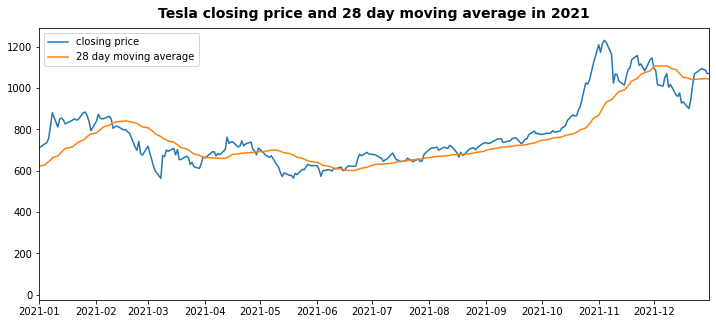

<IPython.core.display.Javascript object>

In [13]:
# plot the result for tesla to demonstrate output of window function
tsla = ex2_pandas[ex2_pandas["ticker"] == "tsla"]

plt.figure(figsize=(12, 5))
plt.plot(pd.to_datetime(tsla["Date"]), tsla["closing_price"], label="closing price")
plt.plot(pd.to_datetime(tsla["Date"]), tsla["ma_28_day"], label="28 day moving average")
plt.xlim(
    datetime.date(2021, 1, 1),
    datetime.date(2021, 12, 31),
)
plt.legend()
plt.title(
    "Tesla closing price and 28 day moving average in 2021",
    fontsize=14,
    fontweight="bold",
    pad=10,
)
plt.show()

In [14]:
# verify that the output of sql and pandas functions were the same
assert all(ex2_sql.ma_28_day == ex2_pandas.ma_28_day)

<IPython.core.display.Javascript object>

### Example 3: Get previous day's closing share price for each ticker

**SQL**

In [15]:
ex3_sql_query = """
SELECT
    date(Date) AS Date
    , ticker
    , closing_price
    , LAG(closing_price, 1) OVER(
        PARTITION BY ticker
        ORDER BY date(Date)
    ) AS previous_close
FROM
    prices
"""

<IPython.core.display.Javascript object>

In [16]:
ex3_sql = pd.read_sql(ex3_sql_query, con=conn)
ex3_sql

,Date,ticker,closing_price,previous_close
0,2018-01-02,aapl,41.188160,NaN
1,2018-01-03,aapl,41.181000,41.188160
2,2018-01-04,aapl,41.372276,41.181000
3,2018-01-05,aapl,41.843311,41.372276
4,2018-01-08,aapl,41.687897,41.843311
...,...,...,...,...
4027,2021-12-27,tsla,1093.939941,1067.000000
4028,2021-12-28,tsla,1088.469971,1093.939941
4029,2021-12-29,tsla,1086.189941,1088.469971
4030,2021-12-30,tsla,1070.339966,1086.189941


<IPython.core.display.Javascript object>

**Pandas**

In this example, we don't need to use the `transform` function because `shift` naturally returns a value for each row in the data, rather than an aggregation.

In [17]:
ex3_pandas = prices.copy()

ex3_pandas["previous_close"] = (
    ex3_pandas.sort_values("Date").groupby("ticker")["closing_price"].shift(1)
)

ex3_pandas

,Date,ticker,closing_price,previous_close
0,2018-01-02,aapl,41.188160,NaN
1,2018-01-03,aapl,41.181000,41.188160
2,2018-01-04,aapl,41.372276,41.181000
3,2018-01-05,aapl,41.843311,41.372276
4,2018-01-08,aapl,41.687897,41.843311
...,...,...,...,...
4027,2021-12-27,tsla,1093.939941,1067.000000
4028,2021-12-28,tsla,1088.469971,1093.939941
4029,2021-12-29,tsla,1086.189941,1088.469971
4030,2021-12-30,tsla,1070.339966,1086.189941


<IPython.core.display.Javascript object>

### Example 4: Daily Percentage Return

**SQL**

In order to calculate the daily return we need to calculate the previous close in a subquery (or CTE) and then use that value to calculate the percentage change increase or daily return.

In [18]:
ex4_sql_query = """
SELECT
    Date
    , ticker
    , closing_price
    , closing_price/previous_close - 1 AS daily_return
FROM
    (
    SELECT
         date(Date) AS Date
        , ticker
        , closing_price
        , LAG(closing_price,1) OVER(
            PARTITION BY ticker ORDER BY date(Date)
        ) AS previous_close
    FROM
        prices
)
"""

<IPython.core.display.Javascript object>

In [19]:
ex4_sql = pd.read_sql(ex4_sql_query, con=conn)
ex4_sql

,Date,ticker,closing_price,daily_return
0,2018-01-02,aapl,41.188160,NaN
1,2018-01-03,aapl,41.181000,-0.000174
2,2018-01-04,aapl,41.372276,0.004645
3,2018-01-05,aapl,41.843311,0.011385
4,2018-01-08,aapl,41.687897,-0.003714
...,...,...,...,...
4027,2021-12-27,tsla,1093.939941,0.025248
4028,2021-12-28,tsla,1088.469971,-0.005000
4029,2021-12-29,tsla,1086.189941,-0.002095
4030,2021-12-30,tsla,1070.339966,-0.014592


<IPython.core.display.Javascript object>

**Pandas**

Here we can use the lambda function syntax to apply a more complex calculation to each group.

In [20]:
ex4_pandas = prices.copy()

ex4_pandas["daily_return"] = (
    ex4_pandas.sort_values("Date")
    .groupby("ticker")["closing_price"]
    .transform(lambda x: x / x.shift(1) - 1)
)

ex4_pandas

,Date,ticker,closing_price,daily_return
0,2018-01-02,aapl,41.188160,NaN
1,2018-01-03,aapl,41.181000,-0.000174
2,2018-01-04,aapl,41.372276,0.004645
3,2018-01-05,aapl,41.843311,0.011385
4,2018-01-08,aapl,41.687897,-0.003714
...,...,...,...,...
4027,2021-12-27,tsla,1093.939941,0.025248
4028,2021-12-28,tsla,1088.469971,-0.005000
4029,2021-12-29,tsla,1086.189941,-0.002095
4030,2021-12-30,tsla,1070.339966,-0.014592


<IPython.core.display.Javascript object>

In [21]:
# verify that the output of sql and pandas functions were the same
assert all(
    ex4_sql.daily_return.fillna(0).values == ex4_pandas.daily_return.fillna(0).values
)

<IPython.core.display.Javascript object>

### Example 5: Missing Data Interpolation

**Pandas**

For last this example we will just use Pandas to demonstrate how to use window type functions to interpolate missing data. 

First we randomly remove some data to simulate missing data in a real world dataset.

We can then use interpolation or imputation functions to fill in the gaps within each group with a quantity that makes the most sense for the situation. For our use case we will use the 'forward fill' method to impute the value of the previous closing price if the data is missing. 

In [22]:
# copy orginal dataframe
ex5_pandas = prices.copy()

# remove 30% of data randomly
pct_missing = 0.3
num_missing = int(pct_missing * len(ex5_pandas))
indexes = random.sample(range(len(ex5_pandas)), k=num_missing)
mask = [i in indexes for i in range(len(ex5_pandas))]

<IPython.core.display.Javascript object>

In [23]:
# mask the dataframe with some random NaNs
ex5_pandas["closing_price"] = ex5_pandas["closing_price"].mask(mask)

<IPython.core.display.Javascript object>

In [24]:
# interpolate missing data paritioned by ticker
ex5_pandas["closing_price_interpolated"] = (
    ex5_pandas.sort_values("Date")
    .groupby("ticker")["closing_price"]
    .transform(lambda x: x.interpolate(method="ffill"))
)

ex5_pandas

,Date,ticker,closing_price,closing_price_interpolated
0,2018-01-02,aapl,41.188160,41.188160
1,2018-01-03,aapl,41.181000,41.181000
2,2018-01-04,aapl,41.372276,41.372276
3,2018-01-05,aapl,NaN,41.372276
4,2018-01-08,aapl,41.687897,41.687897
...,...,...,...,...
4027,2021-12-27,tsla,NaN,1067.000000
4028,2021-12-28,tsla,1088.469971,1088.469971
4029,2021-12-29,tsla,1086.189941,1086.189941
4030,2021-12-30,tsla,NaN,1086.189941


<IPython.core.display.Javascript object>

In [25]:
# verify there is no missing data in the new column
ex5_pandas.isnull().sum()

Date                             0
ticker                           0
closing_price                 1209
closing_price_interpolated       0
dtype: int64

<IPython.core.display.Javascript object>

## Conclusion

It is an important skill as a data scientist to be flexible enough to be able to carry out data transformation in either SQL or Pandas when completing data analysis.

Sometimes it is easier in one language than another to express the data transformation you want, but it is important to understand how common data transformations, such as window functions, can be achieved in either language.

The `transform` function in Pandas can be used to achieve SQL window function like transformations on Pandas dataframes and is a great addition to your tool box.

Happy coding!